# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from google.colab import drive

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
# Baca file CSV
data = pd.read_csv('/content/drive/MyDrive/beverage-sales_clustered.csv')

# Tampilkan DataFrame untuk memastikan telah dibaca dengan benar
data.info()
print('\n')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75948 entries, 0 to 75947
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order_ID       75948 non-null  object 
 1   Customer_ID    75948 non-null  object 
 2   Customer_Type  75948 non-null  object 
 3   Product        75948 non-null  object 
 4   Category       75948 non-null  object 
 5   Unit_Price     75948 non-null  float64
 6   Quantity       75948 non-null  float64
 7   Discount       75948 non-null  float64
 8   Total_Price    75948 non-null  float64
 9   Region         75948 non-null  object 
 10  Order_Date     75948 non-null  object 
 11  Cluster        75948 non-null  int64  
dtypes: float64(4), int64(1), object(7)
memory usage: 7.0+ MB




,Order_ID,Customer_ID,Customer_Type,Product,Category,Unit_Price,Quantity,Discount,Total_Price,Region,Order_Date,Cluster
0,ORD697566,CUS6363,B2C,Coca-Cola,Soft Drinks,1.04,7.0,0.00,7.28,Bremen,2021-02-17,0
1,ORD1118443,CUS7797,B2B,Selters,Water,0.71,46.0,0.10,29.39,Sachsen-Anhalt,2023-04-15,3
2,ORD1437128,CUS6393,B2B,Monster,Soft Drinks,2.68,30.0,0.05,76.38,Schleswig-Holstein,2021-09-07,3
3,ORD562794,CUS4090,B2C,San Pellegrino,Water,0.91,3.0,0.00,2.73,Hessen,2023-04-28,0
4,ORD2320519,CUS5936,B2C,Beck's,Alcoholic Beverages,1.41,4.0,0.00,5.64,Bremen,2023-11-01,0


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [54]:
# Drop kolom yang kurang relevan
data = data.drop(columns=['Order_ID','Customer_ID','Order_Date'])

# Drop data duplikat
data = data.drop_duplicates(ignore_index=True)

# Cek data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43196 entries, 0 to 43195
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Customer_Type  43196 non-null  object 
 1   Product        43196 non-null  object 
 2   Category       43196 non-null  object 
 3   Unit_Price     43196 non-null  float64
 4   Quantity       43196 non-null  float64
 5   Discount       43196 non-null  float64
 6   Total_Price    43196 non-null  float64
 7   Region         43196 non-null  object 
 8   Cluster        43196 non-null  int64  
dtypes: float64(4), int64(1), object(4)
memory usage: 3.0+ MB


In [55]:
# Pisahkan fitur (X) dan target (y)
X = data.drop(columns=['Cluster'])
y = data['Cluster']

X.head()

,Customer_Type,Product,Category,Unit_Price,Quantity,Discount,Total_Price,Region
0,B2C,Coca-Cola,Soft Drinks,1.04,7.0,0.00,7.28,Bremen
1,B2B,Selters,Water,0.71,46.0,0.10,29.39,Sachsen-Anhalt
2,B2B,Monster,Soft Drinks,2.68,30.0,0.05,76.38,Schleswig-Holstein
3,B2C,San Pellegrino,Water,0.91,3.0,0.00,2.73,Hessen
4,B2C,Beck's,Alcoholic Beverages,1.41,4.0,0.00,5.64,Bremen


In [56]:
# Buat instance MinMaxScaler
scaler = MinMaxScaler()

# Normalisasi semua kolom numerik
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

X.head()

,Customer_Type,Product,Category,Unit_Price,Quantity,Discount,Total_Price,Region
0,B2C,Coca-Cola,Soft Drinks,0.117647,0.089552,0.0,0.042820,Bremen
1,B2B,Selters,Water,0.063725,0.671642,1.0,0.178848,Sachsen-Anhalt
2,B2B,Monster,Soft Drinks,0.385621,0.432836,0.5,0.467946,Schleswig-Holstein
3,B2C,San Pellegrino,Water,0.096405,0.029851,0.0,0.014827,Hessen
4,B2C,Beck's,Alcoholic Beverages,0.178105,0.044776,0.0,0.032730,Bremen


In [57]:
# Buat instance LabelEncoder
encoder = LabelEncoder()

# Melakukan encoding pada kolom kategorikal
categorical_columns = X.select_dtypes(include=['object']).columns
for column in categorical_columns:
    X[column] = encoder.fit_transform(X[column])

X.head()

,Customer_Type,Product,Category,Unit_Price,Quantity,Discount,Total_Price,Region
0,1,5,2,0.117647,0.089552,0.0,0.042820,4
1,0,32,3,0.063725,0.671642,1.0,0.178848,13
2,0,20,2,0.385621,0.432836,0.5,0.467946,14
3,1,29,3,0.096405,0.029851,0.0,0.014827,6
4,1,2,0,0.178105,0.044776,0.0,0.032730,4


In [58]:
# Split data menjadi set pelatihan dan set uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Tampilkan bentuk set pelatihan dan set uji untuk memastikan split
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training set shape: X_train=(34556, 8), y_train=(34556,)
Test set shape: X_test=(8640, 8), y_test=(8640,)


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [59]:
nb = GaussianNB().fit(X_train, y_train)
rf = RandomForestClassifier(random_state=69).fit(X_train, y_train)

print("Model training selesai.")

Model training selesai.


Tulis narasi atau penjelasan algoritma yang Anda gunakan.

- **Random Forest** adalah algoritma ensemble yang menggunakan sejumlah besar pohon keputusan (decision trees) untuk meningkatkan akurasi klasifikasi dan mengurangi overfitting yang mungkin terjadi pada pohon keputusan tunggal.
  - Prinsip Kerja: Random Forest membangun banyak pohon keputusan menggunakan subset acak dari data pelatihan dan subset acak dari fitur (fitur yang digunakan untuk membagi data pada setiap pohon). Setiap pohon dalam hutan ini memberikan "suara" (prediksi), dan hasil akhirnya adalah hasil mayoritas dari semua pohon (untuk klasifikasi) atau rata-rata (untuk regresi).
- **Naive Bayes** adalah algoritma klasifikasi berbasis probabilitas yang mengasumsikan bahwa fitur-fitur dalam data bersifat independen satu sama lain, yang merupakan asumsi yang cukup "naif" dalam banyak kasus. Namun, meskipun asumsi ini sering kali tidak sepenuhnya benar, Naive Bayes bisa memberikan hasil yang baik, terutama untuk dataset yang besar dan sederhana.
  - Prinsip Kerja: Naive Bayes didasarkan pada teorema Bayes, yang menghitung probabilitas suatu kelas berdasarkan data fitur. Algoritma ini mengasumsikan bahwa fitur-fitur dalam data saling independen, sehingga kita dapat menghitung probabilitas kelas dengan mengalikan probabilitas masing-masing fitur. Model ini menghitung probabilitas posterior dari kelas, dan memilih kelas dengan probabilitas tertinggi.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

Random Forest Classification Report:
               precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      4774
           1    0.99749   0.99498   0.99623      1196
           2    0.99703   0.99926   0.99814      1345
           3    0.99472   0.99472   0.99472      1325

    accuracy                        0.99838      8640
   macro avg    0.99731   0.99724   0.99727      8640
weighted avg    0.99838   0.99838   0.99838      8640



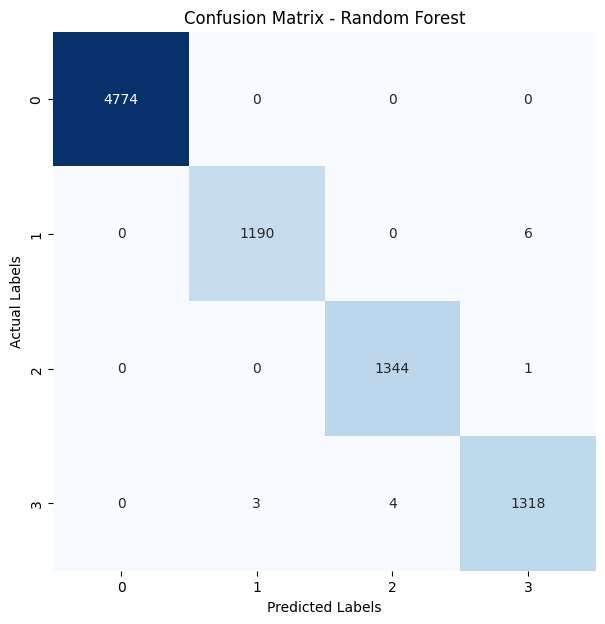

In [60]:
unique_labels = sorted(set(y))

# -----------------------------
# Random Forest
# -----------------------------

rf_y_pred = rf.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_y_pred, digits=5))

rf_cm = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(7, 7))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()
print('\n')

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      4774
           1    0.98003   0.98495   0.98249      1196
           2    0.95723   0.96506   0.96113      1345
           3    0.95031   0.93811   0.94417      1325

    accuracy                        0.98299      8640
   macro avg    0.97189   0.97203   0.97195      8640
weighted avg    0.98296   0.98299   0.98296      8640



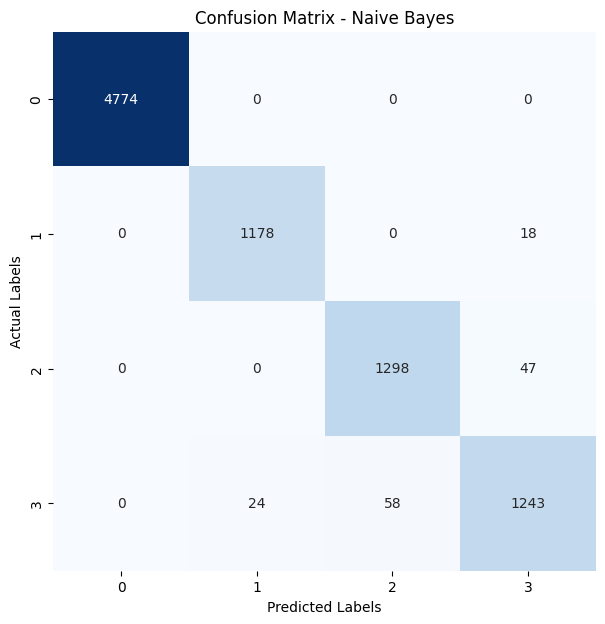

In [61]:
# -----------------------------
# Naive Bayes
# -----------------------------

nb_y_pred = nb.predict(X_test)
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_y_pred, digits=5))

nb_cm = confusion_matrix(y_test, nb_y_pred)
plt.figure(figsize=(7, 7))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

Tulis hasil evaluasi algoritma yang digunakan, jika Anda menggunakan 2 algoritma, maka bandingkan hasilnya.

In [67]:
# Calculate classification reports for both models
rf_report = classification_report(y_test, rf_y_pred, digits=5, output_dict=True)
nb_report = classification_report(y_test, nb_y_pred, digits=5, output_dict=True)

# Extract relevant metrics (accuracy, precision, recall, F1 score)
metrics = {
    'Model': ['Random Forest', 'Naive Bayes'],
    'Accuracy': [rf_report['accuracy'], nb_report['accuracy']],
    'Precision': [rf_report['weighted avg']['precision'], nb_report['weighted avg']['precision']],
    'Recall': [rf_report['weighted avg']['recall'], nb_report['weighted avg']['recall']],
    'F1-Score': [rf_report['weighted avg']['f1-score'], nb_report['weighted avg']['f1-score']]
}

# Create a DataFrame
df = pd.DataFrame(metrics)

df

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.998380,0.998380,0.998380,0.998379
1,Naive Bayes,0.982986,0.982957,0.982986,0.982962


## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [63]:
# --------------------------------------------
# 1. Random Forest Model Hyperparameter Tuning
# --------------------------------------------

# Define Random Forest hyperparameters
rf_param_dist = {
    'n_estimators': np.arange(50, 500, 50),  # Number of trees in the forest
    'max_depth': np.arange(5, 50, 5),         # Maximum depth of each tree
    'min_samples_split': np.arange(2, 20, 2), # Minimum samples required to split a node
    'min_samples_leaf': np.arange(1, 20, 2),  # Minimum samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2'], # The number of features to consider at each split
    'bootstrap': [True, False]                # Whether bootstrap samples are used when building trees
}

# Perform RandomizedSearchCV for RandomForest
rf_random_search = RandomizedSearchCV(  estimator=RandomForestClassifier(random_state=69),  # Model to tune
                                        param_distributions=rf_param_dist,  # Hyperparameter search space
                                        n_iter=100,  # Number of random combinations to test
                                        cv=3,  # 3-fold cross-validation for model evaluation
                                        verbose=2,  # Show detailed progress during the search
                                        random_state=69,  # Set seed for reproducibility
                                        n_jobs=-1  # Use all CPU cores for parallel processing
)

# Fit the model on the training data
rf_random_search.fit(X_train, y_train)

# ------------------------------------------
# 2. Naive Bayes Model Hyperparameter Tuning
# ------------------------------------------

# Define Naive Bayes hyperparameters
nb_param_dist = {
    'var_smoothing': np.logspace(0, -9, num=100)  # Smoothing parameter
}

# Perform RandomizedSearchCV for Naive Bayes
nb_random_search = RandomizedSearchCV(estimator=GaussianNB(),
                                      param_distributions=nb_param_dist,
                                      n_iter=100,
                                      cv=3,
                                      verbose=2,
                                      random_state=69,
                                      n_jobs=-1)

# Fit the model on the training data
nb_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-0...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   random_state=69, verbose=2)

## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

In [64]:
# -----------------------------
# 1. Random Forest
# -----------------------------

# Print the best parameters and score
print("Best Random Forest Hyperparameters:", rf_random_search.best_params_)
print("Best Random Forest Accuracy:", rf_random_search.best_score_)

# Predict and evaluate the Random Forest model
rf_best_model = rf_random_search.best_estimator_
rf_best_model_y_pred = rf_best_model.predict(X_test)
print("Random Forest (best model) Classification Report:\n", classification_report(y_test, rf_best_model_y_pred, digits=5))

# -----------------------------
# 2. Naive Bayes
# -----------------------------

# Print the best parameters and score
print("Best Naive Bayes Hyperparameters:", nb_random_search.best_params_)
print("Best Naive Bayes Accuracy:", nb_random_search.best_score_)

# Predict and evaluate the Naive Bayes model
nb_best_model = nb_random_search.best_estimator_
nb_best_model_y_pred = nb_best_model.predict(X_test)
print("Naive Bayes (best model) Classification Report:\n", classification_report(y_test, nb_best_model_y_pred, digits=5))

Best Random Forest Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 45, 'bootstrap': False}
Best Random Forest Accuracy: 0.9992765324476579
Random Forest (best model) Classification Report:
               precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      4774
           1    1.00000   0.99833   0.99916      1196
           2    0.99777   1.00000   0.99889      1345
           3    0.99849   0.99774   0.99811      1325

    accuracy                        0.99942      8640
   macro avg    0.99907   0.99902   0.99904      8640
weighted avg    0.99942   0.99942   0.99942      8640

Best Naive Bayes Hyperparameters: {'var_smoothing': 2.310129700083158e-08}
Best Naive Bayes Accuracy: 0.9850676709228395
Naive Bayes (best model) Classification Report:
               precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000      4774
           1    0.980

In [68]:
# Calculate classification reports for both models
rf_best_report = classification_report(y_test, rf_best_model_y_pred, digits=5, output_dict=True)
nb_best_report = classification_report(y_test, nb_best_model_y_pred, digits=5, output_dict=True)

# Extract relevant metrics (accuracy, precision, recall, F1 score)
metrics_tuned = {
    'Model': ['Random Forest (Tuned)', 'Naive Bayes (Tuned)'],
    'Accuracy': [rf_best_report['accuracy'], nb_best_report['accuracy']],
    'Precision': [rf_best_report['weighted avg']['precision'], nb_best_report['weighted avg']['precision']],
    'Recall': [rf_best_report['weighted avg']['recall'], nb_best_report['weighted avg']['recall']],
    'F1-Score': [rf_best_report['weighted avg']['f1-score'], nb_best_report['weighted avg']['f1-score']]
}

# Create a DataFrame
df_tuned = pd.DataFrame(metrics_tuned)

df_tuned

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest (Tuned),0.999421,0.999422,0.999421,0.999421
1,Naive Bayes (Tuned),0.982986,0.982957,0.982986,0.982962


## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall rendah untuk kelas tertentu.
  - Apakah model mengalami overfitting atau underfitting?
3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.

In [73]:
df_merged = pd.concat([df, df_tuned], ignore_index=True)
df_merged.iloc[[1, 2]] = df_merged.iloc[[2, 1]].values
df_merged

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.998380,0.998380,0.998380,0.998379
1,Random Forest (Tuned),0.999421,0.999422,0.999421,0.999421
2,Naive Bayes,0.982986,0.982957,0.982986,0.982962
3,Naive Bayes (Tuned),0.982986,0.982957,0.982986,0.982962


- Precision atau Recall rendah untuk kelas tertentu:
  - Tidak ada indikasi precision atau recall yang rendah untuk kelas tertentu, karena kedua metrik ini cukup tinggi untuk semua model. Namun, model Naive Bayes sedikit lebih rendah dibandingkan dengan Random Forest, yang mungkin menunjukkan bahwa Random Forest lebih baik menangani distribusi kelas atau fitur yang lebih kompleks.

- Overfitting atau Underfitting:
  - Overfitting: Tidak ada bukti yang menunjukkan overfitting, terutama pada Random Forest dan model yang telah dituning. Model ini menunjukkan performa stabil yang menunjukkan pemodelan yang baik tanpa terlalu cocok dengan data pelatihan.
  - Underfitting: Tidak ada bukti yang menunjukkan Underfitting.